In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import dates as mpl_dates

In [2]:
df = pd.read_csv('data/cleaned_data', parse_dates = ['date'],
                index_col = 'date', dtype = {'officer_race': 'category',
                                            'officer_gender': 'category',
                                            'subject_age':'category', 'subject_race':'category',
                                            'subject_gender':'category', 'stop_resolution':'category',
                                            'weapon_type':'category', 'call_type':'category', 'arrest':'int32',
                                            'frisk':'float', 'precint':'category', 'sector':'category', 
                                            'beat':'category'})
df.sort_index(inplace = True)
df['count'] = 1

In [3]:
df.date = df.copy()
df = df.loc['2015-04':'2021-09']
df = df['count'].resample('M').count()

<ipython-input-3-c13d2953e154>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.date = df.copy()


Text(0, 0.5, 'Number of Stops')

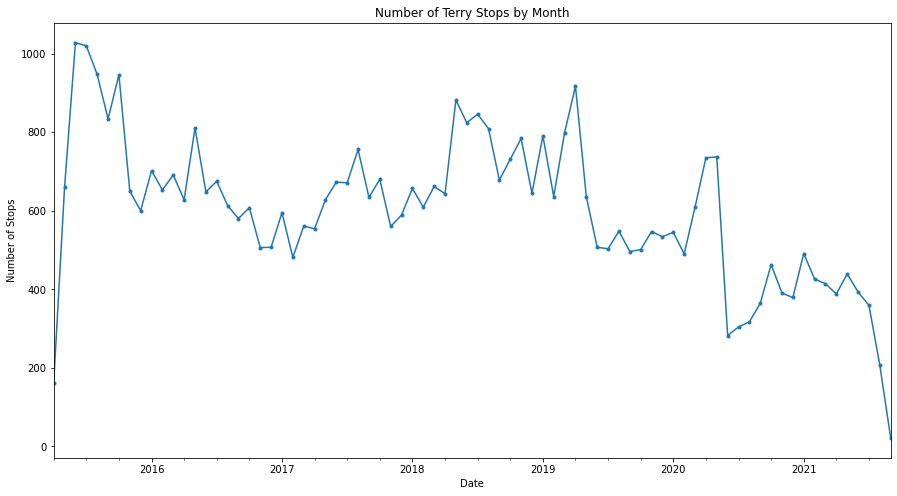

In [4]:
df.plot(marker = '.', linestyle = None, figsize = (15, 8))
plt.title('Number of Terry Stops by Month')
plt.xlabel('Date')
plt.ylabel('Number of Stops')

C:\Users\Le\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-30-096175fa0996>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax = ax.set_xticklabels(dates)


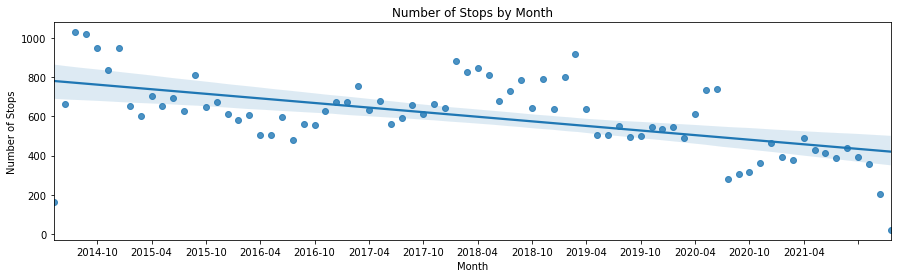

In [30]:
import matplotlib.ticker as ticker

y = df.values
x = np.linspace(1, len(y), num = len(y))

plt.figure(figsize = (15,4))
ax = plt.subplot(1,1,1)
p = sns.regplot(x, y)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
dates = pd.date_range(start= '2014-04-30', end = "2021-09-30", freq = '6M')
dates = [d.strftime('%Y-%m') for d in dates]
ax = ax.set_xticklabels(dates)

plt.title('Number of Stops by Month')
plt.xlabel('Month')
plt.ylabel('Number of Stops');